In [1]:
import pandas as pd
import numpy as np
import pypsa

from pathlib import Path

In [3]:
path = Path.cwd().parent / 'resources' / 'networks'

In [5]:
from pathlib import Path
import geopandas as gpd

eso = gpd.read_file(Path.cwd().parent / 'data' / 'eso_zonal_shapes.geojson')
eso = eso.set_index("name")
eso = eso.loc[eso.index.str.contains("GB")]
# eso.to_file(Path.cwd().parent / 'data' / 'eso_zones.geojson', driver='GeoJSON')

fti = gpd.read_file(Path.cwd().parent / 'data' / 'fti_zonal_shapes.geojson')
fti = fti.rename(columns={"NEW_ZONE1": "name"}).set_index("name")[["geometry"]].set_crs("EPSG:27700").to_crs("EPSG:4326")

In [6]:
def make_busmap(n, zones):
    df = gpd.GeoDataFrame(
        index=n.buses.index,
        geometry=gpd.points_from_xy(n.buses.x, n.buses.y),
        crs="EPSG:4326",
        )

    return gpd.sjoin(df, zones, how="left", op="within").rename(columns={"index_right": 0})[0]

print(make_busmap(n, fti))


Bus
8838    GB5 - North England and North Wales
8013                   GB1 - North Scotland
8520                   GB3 - South Scotland
8649                         GB6 - Midlands
4950                          GB7 - Central
                       ...                 
7458                          GB7 - Central
8283                          GB7 - Central
8094                          GB7 - Central
8093                          GB7 - Central
7908                         GB6 - Midlands
Name: 0, Length: 400, dtype: object


c:\Users\lukas\miniforge3\envs\pypsa-eur\lib\site-packages\IPython\core\interactiveshell.py:3526: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [7]:
import pypsa
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt

from pathlib import Path

In [10]:
fti = gpd.read_file(Path.cwd().parent / 'resources' / 'regions_onshore_elec_2024-03-02_20_s_fti.geojson')
eso = gpd.read_file(Path.cwd().parent / 'resources' / 'regions_onshore_elec_2024-03-02_20_s_eso.geojson')
nodal = gpd.read_file(Path.cwd().parent / 'resources' / 'regions_onshore_2024-03-02_20_s.geojson')

fti_n = pypsa.Network(Path.cwd().parent / 'resources' / 'networks' / 'prepared_live_2024-03-02_20_s_fti.nc')
eso_n = pypsa.Network(Path.cwd().parent / 'resources' / 'networks' / 'prepared_live_2024-03-02_20_s_eso.nc')
nodal_n = pypsa.Network(Path.cwd().parent / 'resources' / 'networks' / 'prepared_live_2024-03-02_20_s.nc')

INFO:pypsa.io:Imported network prepared_live_2024-03-02_20_s_fti.nc has buses, carriers, generators, lines, links, loads
INFO:pypsa.io:Imported network prepared_live_2024-03-02_20_s_eso.nc has buses, carriers, generators, lines, links, loads
INFO:pypsa.io:Imported network prepared_live_2024-03-02_20_s.nc has buses, carriers, generators, lines, links, loads


                                                         geometry  p_nom
4950            POLYGON ((-0.02580 52.25177, -0.03433 52.43810...    NaN
4951            POLYGON ((0.27728 51.86433, 0.17083 51.78695, ...    NaN
4952            POLYGON ((-0.01563 51.61857, -0.00822 51.67576...    NaN
4953            POLYGON ((0.39970 51.60048, 0.34726 51.56454, ...    NaN
4955            POLYGON ((0.41942 51.71046, 0.27728 51.86433, ...    NaN
...                                                           ...    ...
8026 offwind                                                 None   77.0
8026 onwind                                                  None   60.0
8037 wind                                                    None    5.0
8283 gas                                                     None    0.0
8283 gas-fired                                               None    0.0

[386 rows x 2 columns]
                                                         geometry  p_nom
GB0 Z10         POLYGON ((0

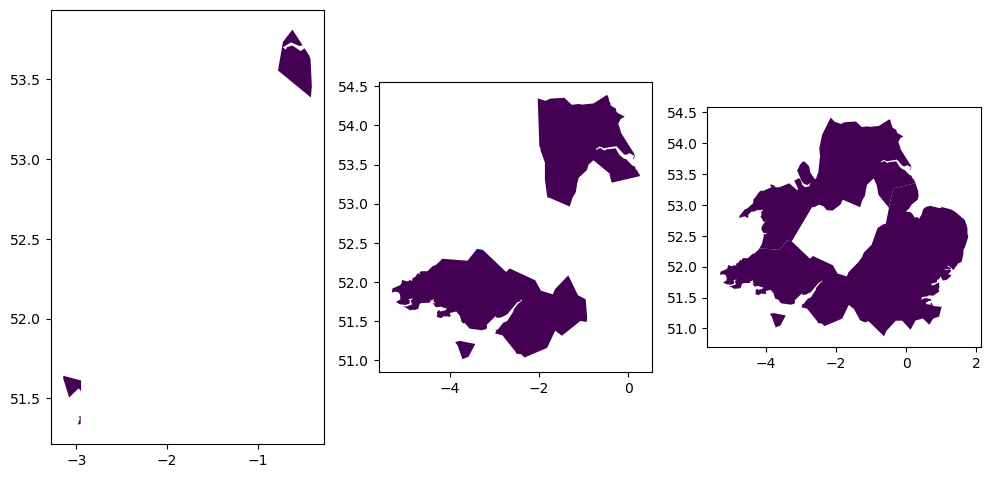

In [46]:
fti_n = pypsa.Network(Path.cwd().parent / 'resources' / 'networks' / 'prepared_live_2024-03-02_20_s_fti.nc')
eso_n = pypsa.Network(Path.cwd().parent / 'resources' / 'networks' / 'prepared_live_2024-03-02_20_s_eso.nc')
nodal_n = pypsa.Network(Path.cwd().parent / 'resources' / 'networks' / 'prepared_live_2024-03-02_20_s.nc')

def fixed_solve(n):
    n.generators.loc[:, "p_nom"] *= n.loads.p_set.sum() / n.generators.p_nom.sum() * 1.1
    n.optimize(solver_name="gurobi")

fixed_solve(nodal_n)
fixed_solve(eso_n)
fixed_solve(fti_n)

INFO:pypsa.io:Imported network prepared_live_2024-03-02_20_s_fti.nc has buses, carriers, generators, lines, links, loads
INFO:pypsa.io:Imported network prepared_live_2024-03-02_20_s_eso.nc has buses, carriers, generators, lines, links, loads
INFO:pypsa.io:Imported network prepared_live_2024-03-02_20_s.nc has buses, carriers, generators, lines, links, loads
c:\Users\lukas\miniforge3\envs\pypsa-eur\lib\site-packages\linopy\expressions.py:176: FutureWarning: the `pandas.MultiIndex` object(s) passed as 'Generator' coordinate(s) or data variable(s) will no longer be implicitly promoted and wrapped into multiple indexed coordinates in the future (i.e., one coordinate for each multi-index level + one dimension coordinate). If you want to keep this behavior, you need to first wrap it explicitly using `mindex_coords = xarray.Coordinates.from_pandas_multiindex(mindex_obj, 'dim')` and pass it as coordinates, e.g., `xarray.Dataset(coords=mindex_coords)`, `dataset.assign_coords(mindex_coords)` or `

Restricted license - for non-production use only - expires 2024-10-28
Read LP format model from file C:\Users\lukas\AppData\Local\Temp\linopy-problem-cm7ldjvd.lp
Reading time = 0.01 seconds
obj: 1622 rows, 592 columns, 3831 nonzeros
Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (win64)

CPU model: 12th Gen Intel(R) Core(TM) i7-12650H, instruction set [SSE2|AVX|AVX2]
Thread count: 10 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 1622 rows, 592 columns and 3831 nonzeros
Model fingerprint: 0xd75ed163
Coefficient statistics:
  Matrix range     [5e-03, 5e+01]
  Objective range  [1e-02, 1e+02]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 6e+03]
Presolve removed 1393 rows and 289 columns
Presolve time: 0.02s
Presolved: 229 rows, 303 columns, 1652 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   1.806141e+05   0.000000e+00      0s
     172    7.0196997e+05   0.000000e+00   0.000000e+0

INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 592 primals, 1622 duals
Objective: 7.02e+05
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Line-fix-s-lower, Line-fix-s-upper, Link-fix-p-lower, Link-fix-p-upper, Kirchhoff-Voltage-Law were not assigned to the network.
c:\Users\lukas\miniforge3\envs\pypsa-eur\lib\site-packages\linopy\expressions.py:176: FutureWarning: the `pandas.MultiIndex` object(s) passed as 'Generator' coordinate(s) or data variable(s) will no longer be implicitly promoted and wrapped into multiple indexed coordinates in the future (i.e., one coordinate for each multi-index level + one dimension coordinate). If you want to keep this behavior, you need to first wrap it explicitly using `mindex_coords = xarray.Coordinates.from_pandas_multiindex(mindex_obj, 'dim')` and pass it as coordinates, e.g., `xarray.Da

Restricted license - for non-production use only - expires 2024-10-28
Read LP format model from file C:\Users\lukas\AppData\Local\Temp\linopy-problem-s2odykd1.lp
Reading time = 0.01 seconds
obj: 266 rows, 119 columns, 420 nonzeros
Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (win64)

CPU model: 12th Gen Intel(R) Core(TM) i7-12650H, instruction set [SSE2|AVX|AVX2]
Thread count: 10 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 266 rows, 119 columns and 420 nonzeros
Model fingerprint: 0xb071106b
Coefficient statistics:
  Matrix range     [1e+00, 3e+01]
  Objective range  [1e-02, 1e+02]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+00, 2e+04]
Presolve removed 243 rows and 57 columns
Presolve time: 0.01s
Presolved: 23 rows, 62 columns, 119 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   2.427811e+04   0.000000e+00      0s
      19    7.0188143e+05   0.000000e+00   0.000000e+00      0s

INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 119 primals, 266 duals
Objective: 7.02e+05
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Line-fix-s-lower, Line-fix-s-upper, Link-fix-p-lower, Link-fix-p-upper, Kirchhoff-Voltage-Law were not assigned to the network.
c:\Users\lukas\miniforge3\envs\pypsa-eur\lib\site-packages\linopy\expressions.py:176: FutureWarning: the `pandas.MultiIndex` object(s) passed as 'Generator' coordinate(s) or data variable(s) will no longer be implicitly promoted and wrapped into multiple indexed coordinates in the future (i.e., one coordinate for each multi-index level + one dimension coordinate). If you want to keep this behavior, you need to first wrap it explicitly using `mindex_coords = xarray.Coordinates.from_pandas_multiindex(mindex_obj, 'dim')` and pass it as coordinates, e.g., `xarray.Dat

Restricted license - for non-production use only - expires 2024-10-28
Read LP format model from file C:\Users\lukas\AppData\Local\Temp\linopy-problem-x55h9kk6.lp
Reading time = 0.01 seconds
obj: 154 rows, 73 columns, 230 nonzeros
Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (win64)

CPU model: 12th Gen Intel(R) Core(TM) i7-12650H, instruction set [SSE2|AVX|AVX2]
Thread count: 10 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 154 rows, 73 columns and 230 nonzeros
Model fingerprint: 0x310efc10
Coefficient statistics:
  Matrix range     [1e+00, 9e+00]
  Objective range  [1e-02, 1e+02]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+00, 1e+04]
Presolve removed 154 rows and 73 columns
Presolve time: 0.01s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    7.0188143e+05   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds (0.00 work units)
Optimal objec

INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 73 primals, 154 duals
Objective: 7.02e+05
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Line-fix-s-lower, Line-fix-s-upper, Link-fix-p-lower, Link-fix-p-upper, Kirchhoff-Voltage-Law were not assigned to the network.


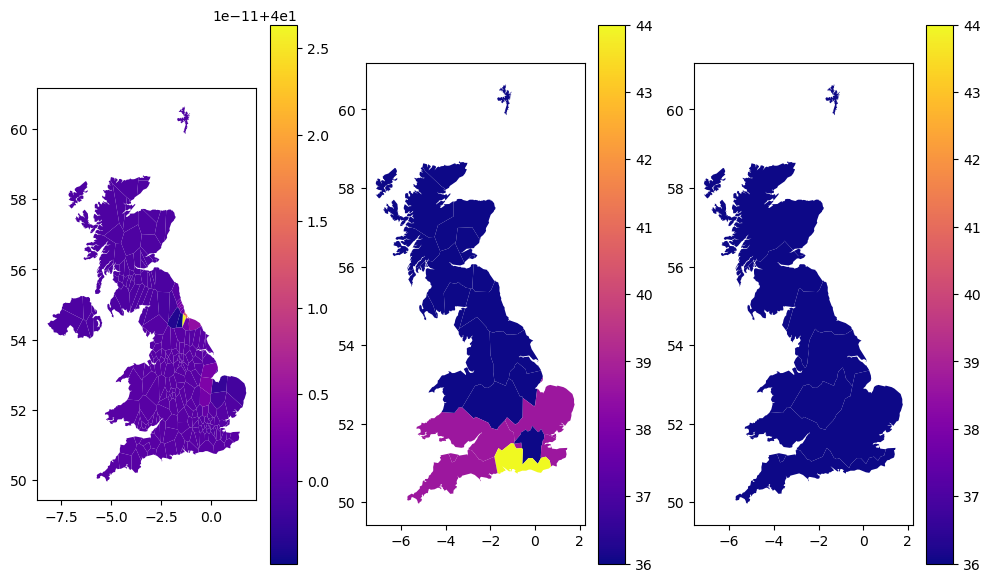

In [54]:
fig, axs = plt.subplots(1, 3, figsize=(12, 7))

vmaxes = {
    "fti": 6000,
    "eso": 2000,
    "nodal": 100,
}

def zones_to_ax(n, zones, ax):# , vmax):

    # print(n.buses_t.marginal_price)
    price = n.buses_t.marginal_price.T
    price.columns = ["marginal_price"]

    merged = pd.concat((zones.set_index("name"), price), axis=1)
    merged.plot(column="marginal_price", ax=ax, legend=True, cmap="plasma")

zones_to_ax(nodal_n, nodal, axs[0])#, vmaxes["nodal"])
zones_to_ax(eso_n, eso, axs[1])#, vmaxes["eso"])
zones_to_ax(fti_n, fti, axs[2])#, vmaxes["fti"])

In [48]:
nodal_n.buses_t.marginal_price

Bus,8838,8013,8649,4950,4951,4952,4953,4955,4956,4958,...,8021,8578,7469,8027,8016,8019,7458,8283,8093,7908
snapshot,,,,,,,,,,,,,,,,,,,,,
2024-02-20 00:30:00,40.0,40.0,40.0,40.0,40.0,40.0,40.0,40.0,40.0,40.0,...,40.0,40.0,40.0,40.0,40.0,40.0,40.0,40.0,40.0,40.0
